In [12]:
import numpy as np
import matplotlib.pyplot as plt 
from skimage import filters
import scipy
import os
import pandas as pd
from collections import Counter
from scipy import stats

from azure.cosmos import CosmosClient
from collections import Counter
import json
import re
from scipy import stats, signal
from sklearn.linear_model import LinearRegression
from scipy.optimize import least_squares


In [13]:
dataFolder=r'S:\Research\Brian\CVCurves\20220901_FunctionalizationRD'
tokenArea= .45  #cm^2

PI_Fluidics_RD, 1.4182, 5.3446 uC/cm^2
PI_Immediate_RD, 1.5241, 4.7821 uC/cm^2
TiAuAl2O3-PirahnaClean10min-overnightMPA_desorp, 0.5910, 0.9946 uC/cm^2


Text(0.5, 0, 'Potential vs Ag/AgCl')

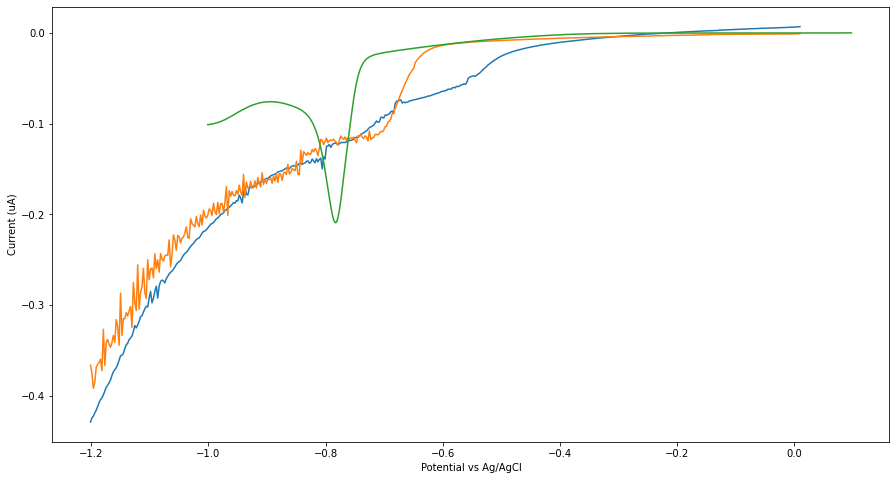

In [33]:
plt.figure(figsize=(15,8))
dir_list = os.listdir(dataFolder)
processed={}
for file in dir_list:
    if '.txt' in file and 'FA' not in file and 'Parallel' not in file:
        cv=pd.read_csv(dataFolder + "\\" + file,sep=';')  
        cv=cv.rename(columns={"Potential applied (V)":"Potential"})
        cv=cv.rename(columns={"WE(1).Current (A)":"Current"})
        cv=cv.rename(columns={"Q+":"Qplus"})
        cv=cv.rename(columns={"Q-":"Qminus"})
        cv=cv.rename(columns={"Time (s)":"Time"})
        cv.Current*=1000
        cv['direction']=np.diff(cv['Potential'],prepend=0)
        
        V=np.array(cv.Potential.loc[ (cv.Scan==1) & (cv.direction<0)])
        C=np.array(cv.Current.loc[ (cv.Scan==1) & (cv.direction<0)])
        T=np.array(cv.Time.loc[ (cv.Scan==1) & (cv.direction<0)])
        plt.plot(V,C,label=file.replace('.txt',''))
        
        data=pd.DataFrame({'Time':T,'Potential':V,"Current":C})
        y=data.Current
        x=data.Time
        iY=np.zeros(len(x))
        Q=0
       
        for i in range(1,len(x)):
            Q+= (y[i]+y[i-1])/2*( x[i]-x[i-1])
            iY[i]=Q/(-1000)*6.24150975e18/tokenArea*1e-18        
        data['Charge']=iY
        processed[file]=data
        
        lin = LinearRegression()
        X=data.Potential*-1
        Y=np.log(np.abs(-1*np.array(data.Current)))
        lin.fit(  np.expand_dims(X,axis=1), Y)
        fit=-1*np.exp( -1*data.Potential* lin.coef_[0]*.92 +lin.intercept_ )
        cor=fit-data.Current
        time=data.Time[cor>0]
        cur = data.Current[cor>0]
        cor = cor[cor>0]
        
        charge =  np.trapz(cor,time) /tokenArea        
        chargeWhole = -1* np.trapz(cur,time) /tokenArea    
        print('%s, %.4f, %.4f uC/cm^2'%(file.replace('.txt',''), charge,chargeWhole))
         
        
        
plt.ylabel("Current (uA)")         
plt.xlabel("Potential vs Ag/AgCl")
#plt.legend()

[-13.18937875   8.38148737] [-10.189378495814097, 8.381487377679434]


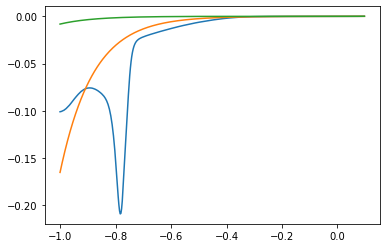

In [19]:
def fun(x, t, y):
        return -1* np.exp(-1*x[1] * t+x[0])#  +  x[2]*t+x[3]
    
x0= [ (lin.intercept_), lin.coef_[0]*.92]#, 0,0]

res_robust = least_squares(fun, x0, args=(data.Current, data.Potential))
print(  (res_robust.x),x0)
plt.plot(data.Potential,data.Current,label=cv)
plt.plot(data.Potential, fun(x0, data.Potential,0))
plt.plot(data.Potential, fun(res_robust.x, data.Potential,0))
#plt.ylim([-.5,0])

PI_Fluidics_RD.txt, 0.1916, 1.0938 uC/cm^2
PI_Immediate_RD.txt, 0.2241, 1.5210 uC/cm^2
PI_Parallel_RD.txt, 0.4447, 1.7763 uC/cm^2


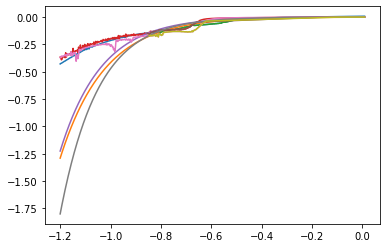

In [32]:

tokenArea = .45/2
for cv in processed:
    data=processed[cv]
    
    lin = LinearRegression()
    X=data.Potential*-1
    Y=np.log(np.abs(-1*np.array(data.Current)))
    lin.fit(  np.expand_dims(X,axis=1), Y)
    fit=-1*np.exp( -1*data.Potential* lin.coef_[0]*1.1 +lin.intercept_ )
    plt.plot(data.Potential,data.Current)
    plt.plot(data.Potential,fit)
    cor=fit-data.Current
    pot=data.Potential[cor>0]
    time=data.Time[cor>0]
    cur = data.Current[cor>0]
    cor = cor[cor>0]
    plt.plot(pot,cur)
    charge =  np.trapz(cor,time) /tokenArea        
    chargeWhole = -1* np.trapz(cur,time) /tokenArea    
    print('%s, %.4f, %.4f uC/cm^2'%(cv, charge,chargeWhole))
    
    
#    plt.plot(time,cor,label=cv)
    #plt.title("%s %.2f uC/cm^2" % (cv,area) )
    #plt.show()

In [251]:
def Diff(time,values):
    return np.diff(values,prepend=0)/np.diff(time,prepend=1)

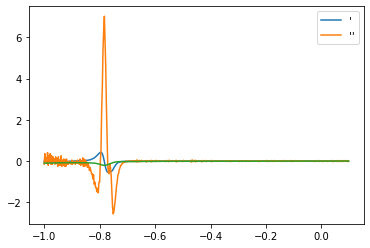

In [252]:
current=np.array(data.Current)
dCurrent =Diff(data.Time, data.Current)
ddCurrent =Diff(data.Time,dCurrent)
plt.plot(data.Potential,dCurrent,label="'")
plt.plot(data.Potential,ddCurrent,label="''")
plt.plot(data.Potential, data.Current)

plt.legend()

[361]


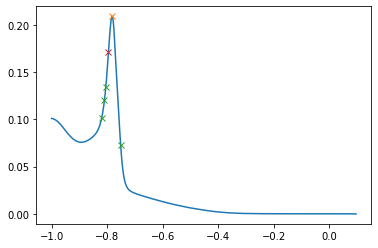

In [255]:
peaks = scipy.signal.find_peaks(current*-1,height=.1 )  [0]
print(peaks)
V=np.array(data.Potential)
plt.plot(data.Potential,-1* data.Current)
plt.plot(V[peaks],-1* current[peaks], "x")

peaks = scipy.signal.find_peaks(ddCurrent*-1,height=1 )  [0]
plt.plot(V[peaks],-1* current[peaks], "x")

peaks = scipy.signal.find_peaks(dCurrent,height=.05 )  [0]
plt.plot(V[peaks],-1* current[peaks], "x")

<AxesSubplot:xlabel='Time'>

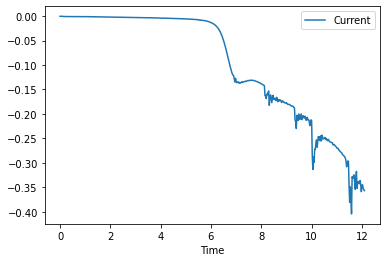

In [52]:
data.plot(x='Time',y="Current")

Text(0, 0.5, 'Charges/Area (e/nm^2)')

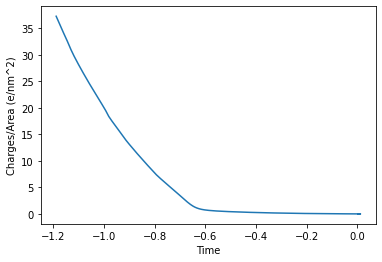

In [68]:
y=data.Current
x=data.Time
iY=np.zeros(len(x))
Q=0
Area= (2e-2 )**2/2
for i in range(1,len(x)):
    Q+= (y[i]+y[i-1])/2*( x[i]-x[i-1])
    iY[i]=Q/-1000*6.24150975e18/Area*1e-18
